In [ ]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_train.npy")
Y_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_train.npy")

X_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_val.npy")
Y_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_val.npy")

X_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_test.npy")
Y_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_test.npy")

In [ ]:
# Divide by the maximum of the training data set for that channel
for i in range(0,4):
    print(np.max(X_train[:,:,i]),np.max(X_val[:,:,i]),np.max(X_test[:,:,i]))
    s0 = np.max(X_train[:,:,i])

    X_train[:,:,i]=X_train[:,:,i]/s0
    X_val[:,:,i]=X_val[:,:,i]/s0
    X_test[:,:,i]=X_test[:,:,i]/s0
    print(np.max(X_train[:,:,i]),np.max(X_val[:,:,i]),np.max(X_test[:,:,i]))

3.088258983890954 2.6634138785625776 2.6445167286245352
1.0 0.8624321640301338 0.8563131338462618
132.61664460622106 132.6009265387161 132.59679020516216
1.0 0.9998814774152096 0.9998502872613174
132.73494374586366 132.72832561217737 132.7448709463931
1.0 0.9999501402306016 1.0000747896540978
5.074349442379182 5.074349442379182 5.074349442379182
1.0 1.0 1.0


In [ ]:
# Switch the location of the time axis and channel axis because CNN layers in pytorch expect channels first
tX_train = np.moveaxis(X_train,2,1)
tY_train = Y_train

tX_val = np.moveaxis(X_val,2,1)
tY_val = Y_val

tX_test = np.moveaxis(X_test,2,1)
tY_test = Y_test

In [ ]:
X_train.shape

(140082, 400, 4)

In [ ]:
dat = X_val
ys = tY_val
i0 = np.min(dat[:,:,0],axis=1)
i1 = np.min(dat[:,:,1],axis=1)
i2 = np.min(dat[:,:,2],axis=1)
i3 = np.min(dat[:,:,3],axis=1)

s0 = np.max(dat[:,:,0],axis=1)
s1 = np.max(dat[:,:,1],axis=1)
s2 = np.max(dat[:,:,2],axis=1)
s3 = np.max(dat[:,:,3],axis=1)

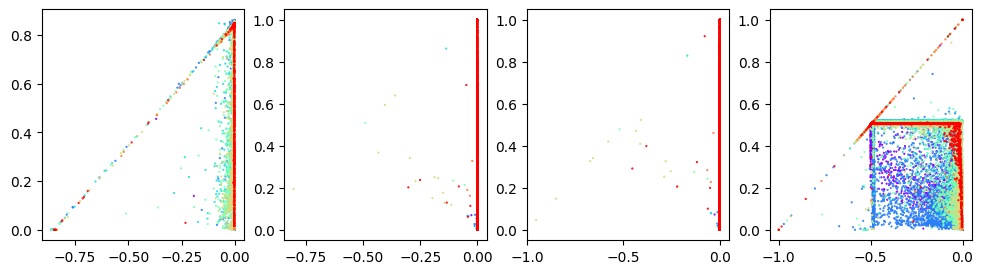

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].scatter(i0,s0,c=ys,cmap='rainbow',s=0.3)
axes[1].scatter(i1,s1,c=ys,cmap='rainbow',s=0.3)
axes[2].scatter(i2,s2,c=ys,cmap='rainbow',s=0.3)
axes[3].scatter(i3,s3,c=ys,cmap='rainbow',s=0.3)

## Set up the pytorch data loaders

In [ ]:
class SP2Datasets(Dataset):
    def __init__(self,purpose,latent=False):

        if purpose == "train":
            self.X = tX_train
            self.Y = tY_train
        elif purpose == "val":
            self.X = tX_val
            self.Y = tY_val
        else:
            self.X = tX_test
            self.Y = tY_test
    def __len__(self):
        return int(self.X.shape[0])
    def __getitem__(self,idx):

        X = self.X[idx,:,:]
        Y = self.Y[idx]

        return X,Y

In [ ]:
bs = 500
traindataset = SP2Datasets("train",bs)
valdataset = SP2Datasets("val",bs)
testdataset = SP2Datasets("test",bs)

In [ ]:
# disable auto load the data in chunks from memory
trainloader = DataLoader(traindataset, batch_size=bs, shuffle=True)
valloader = DataLoader(valdataset, batch_size=bs, shuffle=True)
testloader = DataLoader(testdataset, batch_size=bs, shuffle=True)

In [ ]:
i = 0
j = 0
for data in trainloader:
    x,y=data

    #print(x.shape,y.shape)
    i = i+1
    j = j+x.shape[0]
print(i,j)

281 140082


In [ ]:
st = 2
c1 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
c2 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
c3 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
c4 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
n_latent = 3
lin = Lin(100,n_latent)

In [ ]:
x2 = c1(x.float())
x3 = c2(x2)
x4 = c3(x3)
x5 = c4(x4)
x6 = x5.view(-1,100)
print(x.shape,x2.shape,x3.shape,x4.shape,x5.shape,x6.shape)

torch.Size([82, 4, 400]) torch.Size([82, 4, 200]) torch.Size([82, 4, 100]) torch.Size([82, 4, 50]) torch.Size([82, 4, 25]) torch.Size([82, 100])


## Set up the model

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self,n_channels=4,n_steps=400,n_latent=10):
        super(Encoder, self).__init__()
        self.n_layers = 4
        self.n_steps = n_steps
        self.c1 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation1 = ReLU()
        self.c2 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation2 = ReLU()
        self.c3 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation3 = ReLU()
        self.c4 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation4 = ReLU()
        self.lin = Lin(int(self.n_steps/self.n_layers),n_latent)

    def forward(self,x):

        x = self.c1(x)
        x = self.activation1(x)
        x = self.c2(x)
        x = self.activation2(x)
        x = self.c3(x)
        x = self.activation3(x)
        x = self.c4(x)
        x = self.activation4(x)
        x = x.view(-1,int(self.n_steps/self.n_layers))
        return self.lin(x)

class Decoder(torch.nn.Module):
    def __init__(self,n_channels=4,n_steps=400,n_latent=10):
        super(Decoder, self).__init__()

        self.n_layers = 4
        self.n_steps = n_steps
        self.n_latent = n_latent
        self.n_channels = n_channels

        self.lin = Lin(n_latent,int(self.n_steps/self.n_layers))
        self.conv1 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation1 = ReLU()
        self.conv2 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation2 = ReLU()
        self.conv3 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation3 = ReLU()
        self.conv4 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation4 = ReLU()
        self.lin2 = Lin(n_steps,n_steps)
        self.activation5 = ReLU()

    def forward(self,x):

        inp = x

        x = self.lin(inp)
        x = x.reshape(-1,self.n_channels,int(self.n_steps/self.n_layers/self.n_channels))
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.conv4(x)
        x = self.activation4(x)

        x = self.lin2(x)

        return x #self.activation5(x)

class SP2AutoEncoder(torch.nn.Module):
    def __init__(self,n_channels=4,n_steps=400,n_latent=10):
        super(SP2AutoEncoder, self).__init__()

        self.encoder = Encoder(n_channels=n_channels,n_steps=n_steps,n_latent=n_latent)
        self.decoder = Decoder(n_channels=n_channels,n_steps=n_steps,n_latent=n_latent)

    def forward(self,x):

        bs = x.shape[0]

        latent = self.encoder(x)

        reconstruction = self.decoder(latent) #+x

        return reconstruction,latent

In [ ]:
def recon_loss(recon_x,x):
    mseloss = torch.nn.MSELoss()
    mse = mseloss(recon_x,x)

    return mse

In [ ]:
def train(model,dataloader,criterion,device,epoch):
    model.train()

    for data in dataloader:
        x,y=data

        optimizer.zero_grad()

        xhat,latent = model(x.float())

        mseloss = recon_loss(xhat,x.float())

        loss = mseloss

        loss.backward()

        optimizer.step()

    return model
def test(model,dataloader,criterion,device):
    model.eval()
    correct = 0
    recon = 0

    with torch.no_grad():
        for data in dataloader:
            x,y=data

            xhat,latent = model(x.float())

            mse = recon_loss(xhat.float(),x.float())

            #correct = correct+loss
            nn = len(dataloader.dataset)
            recon = recon+mse

        return recon/nn

def inference(model,dataloader,device, n_latent=6):
    model.eval()
    dataset = dataloader.dataset
    print(len(dataset))
    bs = 500

    realx = np.zeros((len(dataset),4,400))
    predx = np.zeros((len(dataset),4,400))
    realclasses = np.zeros((len(dataset)))
    latentvars = np.zeros((len(dataset),n_latent))

    jj = 0
    i = 0

    for data in dataloader:

        x,y=data

        xhat,latent = model(x.float())

        bs = xhat.shape[0]
        if xhat is not(None):
            realx[jj:jj+bs,:]=x.cpu().detach().numpy().reshape(bs,4,400)
            predx[jj:jj+bs,:]=xhat.cpu().detach().numpy().reshape(bs,4,400)
            realclasses[jj:jj+bs]=y.cpu().detach().numpy().reshape(bs)
            latentvars[jj:jj+bs,:]=latent.cpu().detach().numpy().reshape(bs,n_latent)

            jj=jj+bs
            i = i+1
        else:
            break

    return realx,predx,realclasses,latentvars

In [ ]:
init_lr = 1e-3
weight_decay = 1e-3
total_epochs = 200

# Learning rate strings so its in the correct format for the filenames
lrval='{:3.0e}'.format(init_lr)[0]
lrexp = '{:3.0e}'.format(init_lr)[4]

model = SP2AutoEncoder(n_latent=6)

# Check if there is a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# print(model)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [ ]:
val_accur = []
train_accur = []

train_mse_recs = []
val_mse_recs = []

In [ ]:
e0 = 0
epochs = 60

for epoch in tqdm(range(e0,epochs)):
    mod = train(model,trainloader,criterion,device,epoch)
    train_mse = test(model,trainloader,criterion,device)
    val_mse = test(model,valloader,criterion,device)

    train_mse_recs.append(train_mse)
    val_mse_recs.append(val_mse)
    if epoch%10==0:
      print(f'Epoch: {epoch:03d}, Train MSE: {train_mse:.8e}, Val. MSE: {val_mse:.8e}')



  2%|▏         | 1/60 [00:43<42:41, 43.42s/it]

Epoch: 000, Train MSE: 1.56351834e-05, Val. MSE: 1.58387265e-05


 18%|█▊        | 11/60 [07:50<34:43, 42.52s/it]

Epoch: 010, Train MSE: 3.09614711e-06, Val. MSE: 3.12512975e-06


 35%|███▌      | 21/60 [14:54<27:46, 42.74s/it]

Epoch: 020, Train MSE: 2.40303848e-06, Val. MSE: 2.44401872e-06


 52%|█████▏    | 31/60 [21:51<20:03, 41.50s/it]

Epoch: 030, Train MSE: 2.10480175e-06, Val. MSE: 2.14162765e-06


 68%|██████▊   | 41/60 [28:56<13:29, 42.60s/it]

Epoch: 040, Train MSE: 1.92579728e-06, Val. MSE: 1.96573342e-06


 85%|████████▌ | 51/60 [35:42<06:03, 40.39s/it]

Epoch: 050, Train MSE: 1.82887868e-06, Val. MSE: 1.88070544e-06


100%|██████████| 60/60 [41:47<00:00, 41.80s/it]


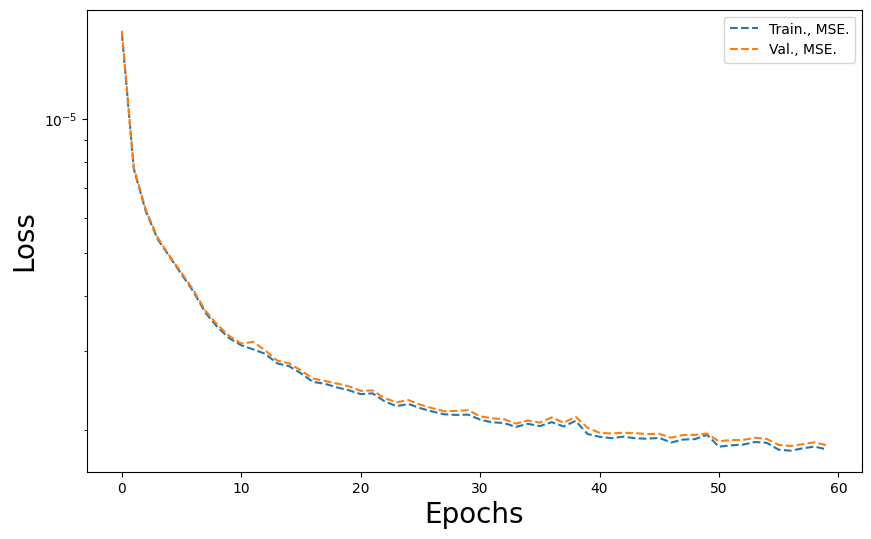

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_mse_recs, label='Train., MSE.',linestyle='dashed')
plt.plot(val_mse_recs,label='Val., MSE.',linestyle='dashed')
plt.yscale('log')
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.legend()
plt.show()

In [ ]:
trainrealx,trainpredx,trainrealy,trainlatent=inference(model,trainloader,device)
valrealx,valpredx,valrealy,vallatent=inference(model,valloader,device)
testrealx,testpredx,testrealy,testlatent=inference(model,testloader,device)

In [ ]:
target_names=["FS","FSglyc","CFA","ATD","VA","Fe2O3","Fe3O4"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].scatter(trainlatent[:,0],trainlatent[:,1],c=trainrealy[:],cmap='rainbow',s=0.3)
axes[1].scatter(vallatent[:,0],vallatent[:,1],c=valrealy[:],cmap='rainbow',s=0.3)
ax2=axes[2].scatter(testlatent[:,0],testlatent[:,1],c=testrealy[:],cmap='rainbow',s=0.3)
cbar = plt.colorbar(ax2)
cbar.set_ticklabels=target_names

In [ ]:
from sklearn.cluster import KMeans
def kmeans(X_train, X_test, train_cluster_labels, num_clusters=7):

  # Initialize the k-means clustering model
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)

  kmeans.fit(X_train)

  # Get the clustering labels to be used for the training data

  # Perform clustering on the test data
  test_cluster_labels = kmeans.predict(X_test)

  # Visualize the training data
  plt.scatter(X_train[:, 0], X_train[:, 1], c=train_cluster_labels, cmap='viridis')
  plt.title('K-means Clustering - Training Data')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.colorbar()
  plt.show()

  # Visualize the test data
  plt.scatter(X_test[:, 0], X_test[:, 1], c=test_cluster_labels, cmap='viridis')
  plt.title('K-means Clustering - Test Data')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.colorbar()
  plt.show()

kmeans(trainlatent, testlatent, trainrealy, 7)